----

### 참여 대회 주제 및 URL

- 주어진 고객 데이터셋(나이, 성별, 월 수입 등)을 이용해 __여행 패키지 신청 여부를 예측__
- https://dacon.io/competitions/official/235959/overview/description

### 최종 순위

- PRIVATE 48위(13.15%) / PUBLIC 34위(9.32%) ㅡ 총 365명 참가

--------

# 목차

1.EDA & Filling Null 
  
    1.1 train, test set 불러오기  
    1.2 feature 분석    
    1.3 msno를 통해 Null값 여부 확인  


2.Data Preprocessing

    2.1 pd.get_dummies와 map을 이용하기  
    2.2 정규화(MinMaxScaler)
    

3.Predictive Modeling

    3.1 Heatmap  
    3.2 train(feature, label) 및 test data 설정  
    3.3 Simple modeling
    3.4 Stacking ensemble

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1)

import missingno as msno 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# 1. EDA & Filling Null

## 1.1 train, test set 불러오기

In [99]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

0번 부터 18번까지는 train에 필요한 feature이고, 19번 __ProdTaken__이 우리가 예측해야 할 여행 패키지 신청 여부이다.  
(아래의 test data에는 ProdTaken이 없음을 확인 할 수 있다.)

In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2933 non-null   int64  
 1   Age                       2801 non-null   float64
 2   TypeofContact             2918 non-null   object 
 3   CityTier                  2933 non-null   int64  
 4   DurationOfPitch           2784 non-null   float64
 5   Occupation                2933 non-null   object 
 6   Gender                    2933 non-null   object 
 7   NumberOfPersonVisiting    2933 non-null   int64  
 8   NumberOfFollowups         2901 non-null   float64
 9   ProductPitched            2933 non-null   object 
 10  PreferredPropertyStar     2917 non-null   float64
 11  MaritalStatus             2933 non-null   object 
 12  NumberOfTrips             2850 non-null   float64
 13  Passport                  2933 non-null   int64  
 14  PitchSat

<< 데이터의 feature에 대한 설명 >>

Age : 나이  
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)  
CityTier : 주거 중인 도시의 등급 (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급)   
DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간  
Occupation : 직업  
Gender : 성별  
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원  
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수  
ProductPitched : 영업 사원이 제시한 상품  
PreferredPropertyStar : 선호 호텔 숙박업소 등급  
MaritalStatus : 결혼여부  
NumberOfTrips : 평균 연간 여행 횟수  
Passport : 여권 보유 여부 (0: 없음, 1: 있음)  
PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도  
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)  
NumberOfChildrenVisiting : 함께 여행을 계획 중인 5세 미만의 어린이 수  
Designation : (직업의) 직급  
MonthlyIncome : 월 급여  
  
ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함) - 예측해야 할 항목

train과 test data를 살펴보면 몇 개의 feature에서 Null값이 있음을 알 수 있다.  
각각의 feature에 대해 EDA 해보고, 적절한 Null값을 채워보고자 한다.

## 1.2 feature 분석

- Null이 존재하는 feature 위주로 분석을 시행해보았다.

###  1.2.1 Age - 나이

In [102]:
train['Age'].isnull().sum()

94

In [103]:
train['Age'].describe()

count    1861.000000
mean       37.462117
std         9.189948
min        18.000000
25%        31.000000
50%        36.000000
75%        43.000000
max        61.000000
Name: Age, dtype: float64

94개의 Null값이 존재하며, 나이의 평균은 37.47임을 알 수 있다.

<AxesSubplot:xlabel='Age', ylabel='Count'>

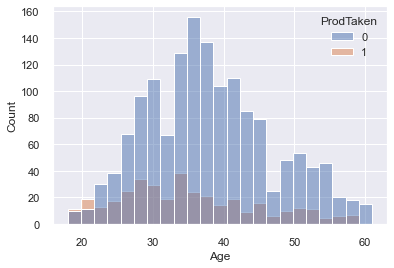

In [104]:
sns.histplot(data=train, x='Age', hue='ProdTaken')

Age와 ProdTaken에 대한 histogram을 그려보았다.  

(1) 20대 초반 : 여행상품을 산 사람 > 안 산 사람  
(2) 30대 중반 : 여행상품을 안 산 사람 > 산 사람  
(3) 그 외 두드러지게 보이는 부분은 없음

(자기 반성) 여기서 분명 ProdTaken과의 관계를 확인했으나, 이것을 반영할 수 있는 Age band와 같은 수단을 사용하지 않았다. - 대회 참가 당시 5, 10살 기준으로 Age band를 만들어 예측을 수행한 결과, public 정확도가 오히려 떨어짐을 확인해서 그 이후로는 사용하지 않았다. 결국은 public에서 과적합이 일어나 private에서 정확도가 더 떨어진 것으로 보인다.

In [105]:
train.groupby('Designation').mean()

,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome,ProdTaken
Designation,,,,,,,,,,,,,,
AVP,997.938462,48.153846,1.730769,16.423077,2.800000,3.623077,3.538462,3.620370,0.292308,3.269231,0.715385,1.103448,32148.438462,0.076923
Executive,978.582550,32.742775,1.318121,14.912378,2.962416,3.694595,3.587366,3.144011,0.312752,3.116779,0.573154,1.229530,20110.209859,0.299329
Manager,955.802612,37.235747,1.921626,16.154723,2.918723,3.688693,3.557329,3.246734,0.275762,3.020319,0.621190,1.210450,22614.373397,0.130624
Senior Manager,996.344371,41.235880,1.807947,16.172757,2.894040,3.837748,3.621262,3.392027,0.278146,2.913907,0.658940,1.182119,26715.056291,0.168874
VP,1053.595506,47.426966,1.483146,12.606742,2.898876,3.876404,3.345679,3.403509,0.269663,3.247191,0.719101,1.368421,35796.179775,0.101124


나중에 살펴볼 feature 중 Designation(직급)이 나이의 특성을 잘 반영할 것이라 판단하여,  
groupby를 이용해 직급별 평균 나이를 구하고 이를 age Null값에 채우고자 한다.

In [106]:
train.loc[(train.Age.isnull()) & (train.Designation == 'AVP'),'Age'] = 49
train.loc[(train.Age.isnull()) & (train.Designation == 'Executive'),'Age'] = 33
train.loc[(train.Age.isnull()) & (train.Designation == 'Manager'),'Age'] = 38
train.loc[(train.Age.isnull()) & (train.Designation == 'Senior Manager'),'Age'] = 42
train.loc[(train.Age.isnull()) & (train.Designation == 'VP'),'Age'] = 48

In [107]:
train['Age'].isnull().sum()

0

#### test data에도 적용 - data leakage를 방지하기 위해 train의 평균 age를 채움

In [108]:
test.loc[(test.Age.isnull()) & (test.Designation == 'AVP'),'Age'] = 49
test.loc[(test.Age.isnull()) & (test.Designation == 'Executive'),'Age'] = 33
test.loc[(test.Age.isnull()) & (test.Designation == 'Manager'),'Age'] = 38
test.loc[(test.Age.isnull()) & (test.Designation == 'Senior Manager'),'Age'] = 42
test.loc[(test.Age.isnull()) & (test.Designation == 'VP'),'Age'] = 48

In [109]:
test['Age'].isnull().sum()

0

### 1.2.2 TypeofContact - 고객의 제품 인지 방법 

In [110]:
train['TypeofContact'].isnull().sum()

10

In [111]:
train['TypeofContact'].value_counts()

Self Enquiry       1379
Company Invited     566
Name: TypeofContact, dtype: int64

TypeofContact의 고유값으로는 Self Enquiry(스스로 검색), Company Invited(회사의 홍보) 2가지가 있으며, 해당 feature의 null값 10개를 최빈값인 Self Enquiry로 채웠다.

In [112]:
train['TypeofContact'].fillna('Self Enquiry',inplace=True)

In [113]:
train['TypeofContact'].isnull().sum()

0

#### test data에도 적용 - data leakage를 방지하기 위해 train 값에 대한 값을 채움

In [114]:
test['TypeofContact'].fillna('Self Enquiry',inplace=True)

In [115]:
test['TypeofContact'].isnull().sum()

0

### 1.2.3 DurationOfPitch - 영업 사원이 고객에게 제공하는 프레젠테이션 기간

In [116]:
train['DurationOfPitch'].describe()

count    1853.000000
mean       15.524015
std         8.150057
min         5.000000
25%         9.000000
50%        14.000000
75%        20.000000
max        36.000000
Name: DurationOfPitch, dtype: float64

In [117]:
train['DurationOfPitch'].median()

14.0

Null값을 채우기 위해 다른 feature와 연계해보거나, 평균 값을 넣어보는 시도를 해봤지만 정확도에 큰 차이가 나지 않아 중앙값인 14를 넣어주었다.

In [118]:
train['DurationOfPitch'].fillna(14, inplace=True)

In [119]:
train['DurationOfPitch'].isnull().sum()

0

In [120]:
test['DurationOfPitch'].isnull().sum()

149

#### test data에도 적용 - data leakage를 방지하기 위해 train 값에 대한 값을 채움

In [121]:
test['DurationOfPitch'].fillna(14, inplace=True) 

In [122]:
test['DurationOfPitch'].isnull().sum()

0

### 1.2.4 NumberOfFollowups - 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수

In [123]:
train['NumberOfFollowups'].isnull().sum()

13

후속 조치가 없었다고 생각하여 Null값을 0으로 채워주었고, test data에도 동일하게 적용했다.

In [124]:
train['NumberOfFollowups'].fillna(0, inplace=True)

In [125]:
test['NumberOfFollowups'].fillna(0, inplace=True)

### 1.2.5 Gender - 성별

In [126]:
train['Gender'].value_counts()

Male       1207
Female      692
Fe Male      56
Name: Gender, dtype: int64

replace를 이용해 Fe Male을 Female로 변경했다.

In [127]:
train['Gender'].replace('Fe Male','Female',inplace=True)

In [128]:
train['Gender'].value_counts()

Male      1207
Female     748
Name: Gender, dtype: int64

test data에도 같은 수정사항을 반영했다.

In [129]:
test['Gender'].replace('Fe Male','Female',inplace=True)

In [130]:
test['Gender'].value_counts()

Male      1709
Female    1224
Name: Gender, dtype: int64

### 1.2.6 NumberOfChildrenVisiting - 함께 여행을 계획 중인 5세 미만의 어린이 수

In [131]:
train['NumberOfChildrenVisiting'].value_counts()

1.0    819
2.0    559
0.0    416
3.0    134
Name: NumberOfChildrenVisiting, dtype: int64

train의 최빈값인 1.0으로 train, test Null값을 채웠다.

In [132]:
train['NumberOfChildrenVisiting'].fillna(1.0, inplace=True)

In [133]:
test['NumberOfChildrenVisiting'].fillna(1.0, inplace=True)

### 1.2.7 PreferredPropertyStar - 선호 호텔 숙박업소 등급

In [134]:
train['PreferredPropertyStar'].value_counts()

3.0    1212
5.0     373
4.0     360
Name: PreferredPropertyStar, dtype: int64

train의 최빈값인 3.0으로 train, test Null값을 채웠다.

In [135]:
train['PreferredPropertyStar'].fillna(3.0, inplace=True)

In [136]:
test['PreferredPropertyStar'].fillna(3.0, inplace=True)

### 1.2.8 NumberOfTrips - 평균 연간 여행횟수

In [137]:
train['NumberOfTrips'].describe()

count    1898.000000
mean        3.255532
std         1.814698
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        19.000000
Name: NumberOfTrips, dtype: float64

In [138]:
train['NumberOfTrips'].median()

3.0

train의 중앙값인 3.0으로 train, test Null값을 채웠다.

In [139]:
train['NumberOfTrips'].fillna(3.0, inplace=True)

In [140]:
test['NumberOfTrips'].fillna(3.0, inplace=True)

### 1.2.8 MonthlyIncome - 월 급여

In [141]:
train.groupby('Designation').mean()['MonthlyIncome']

Designation
AVP               32148.438462
Executive         20110.209859
Manager           22614.373397
Senior Manager    26715.056291
VP                35796.179775
Name: MonthlyIncome, dtype: float64

월 급여는 직급에 따라 Null값을 채우는 것이 가장 좋을 것이라 판단하여  
직급에 따른 월 급여를 산출했고, 이 값을 train, test의 Null값에 동일하게 입력했다.

In [142]:
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='AVP'),'MonthlyIncome'] = 32149
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='Executive'),'MonthlyIncome'] = 20111
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='Manager'),'MonthlyIncome'] = 22615
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='Senior Manager'),'MonthlyIncome'] = 26716
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='VP'),'MonthlyIncome']  = 35797

In [143]:
train.MonthlyIncome.isnull().sum()

0

#### test data에도 적용 - data leakage를 방지하기 위해 train 값에 대한 값을 채움

In [144]:
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='AVP'),'MonthlyIncome'] = 32149
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='Executive'),'MonthlyIncome'] = 20111
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='Manager'),'MonthlyIncome'] = 22615
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='Senior Manager'),'MonthlyIncome'] = 26716
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='VP'),'MonthlyIncome']  = 35797

In [145]:
test.MonthlyIncome.isnull().sum()

0

## 1.3 msno를 통해 Null값 여부 확인

<AxesSubplot:>

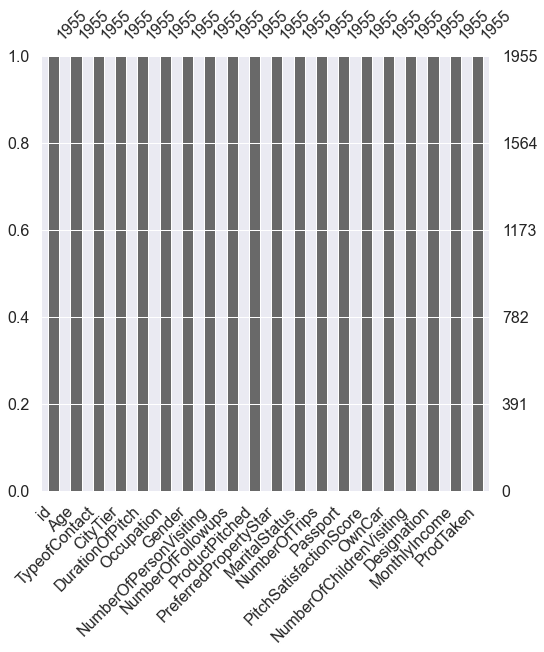

In [146]:
msno.bar(df=train,figsize=(8,8))

<AxesSubplot:>

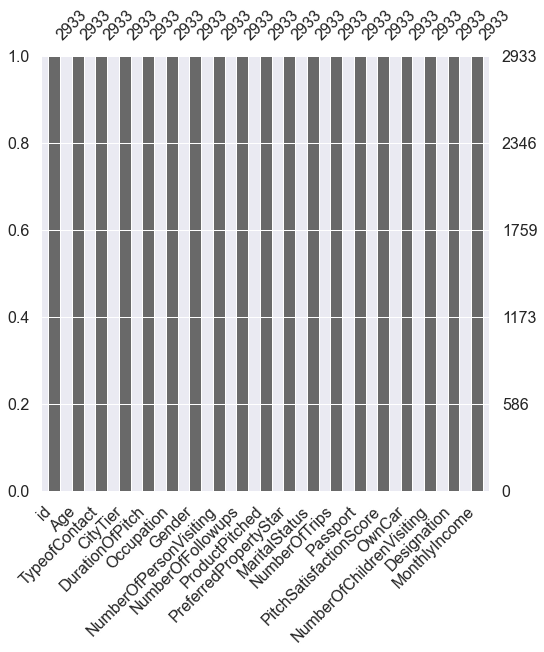

In [147]:
msno.bar(df=test,figsize=(8,8))

# 2. Data Preprocessing

## 2.1 pd.get_dummies와 map을 이용하기

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1955 non-null   float64
 2   TypeofContact             1955 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1955 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1955 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1955 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1955 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

train data 중 object에 해당하는 column을 pd.get_dummies를 이용해 더미변수를 생성하고, map을 이용해 Gender를 0과 1로 변환했다.

In [149]:
train['Gender'] = train['Gender'].map({'Male' : 0, 'Female' : 1})

In [150]:
train = pd.get_dummies(train, columns=['TypeofContact'], prefix='TC')

In [151]:
train = pd.get_dummies(train, columns=['CityTier'], prefix='CityTier')

In [152]:
train = pd.get_dummies(train, columns=['Occupation'], prefix='Occ')

In [153]:
train = pd.get_dummies(train, columns=['ProductPitched'], prefix='Pitched')

In [154]:
train = pd.get_dummies(train, columns=['MaritalStatus'], prefix='Marry')

In [155]:
train = pd.get_dummies(train, columns=['Designation'], prefix='Desig')

In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1955 non-null   float64
 2   DurationOfPitch           1955 non-null   float64
 3   Gender                    1955 non-null   int64  
 4   NumberOfPersonVisiting    1955 non-null   int64  
 5   NumberOfFollowups         1955 non-null   float64
 6   PreferredPropertyStar     1955 non-null   float64
 7   NumberOfTrips             1955 non-null   float64
 8   Passport                  1955 non-null   int64  
 9   PitchSatisfactionScore    1955 non-null   int64  
 10  OwnCar                    1955 non-null   int64  
 11  NumberOfChildrenVisiting  1955 non-null   float64
 12  MonthlyIncome             1955 non-null   float64
 13  ProdTaken                 1955 non-null   int64  
 14  TC_Compa

test도 train과 같은 방법으로 변환해주었다.

In [157]:
test['Gender'] = test['Gender'].map({'Male' : 0, 'Female' : 1})

In [158]:
test = pd.get_dummies(test, columns=['TypeofContact'], prefix='TC')

In [159]:
test = pd.get_dummies(test, columns=['CityTier'], prefix='CityTier')

In [160]:
test = pd.get_dummies(test, columns=['Occupation'], prefix='Occ')

In [161]:
test = pd.get_dummies(test, columns=['ProductPitched'], prefix='Pitched')

In [162]:
test = pd.get_dummies(test, columns=['MaritalStatus'], prefix='Marry')

In [163]:
test = pd.get_dummies(test, columns=['Designation'], prefix='Desig')

In [164]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2933 non-null   int64  
 1   Age                       2933 non-null   float64
 2   DurationOfPitch           2933 non-null   float64
 3   Gender                    2933 non-null   int64  
 4   NumberOfPersonVisiting    2933 non-null   int64  
 5   NumberOfFollowups         2933 non-null   float64
 6   PreferredPropertyStar     2933 non-null   float64
 7   NumberOfTrips             2933 non-null   float64
 8   Passport                  2933 non-null   int64  
 9   PitchSatisfactionScore    2933 non-null   int64  
 10  OwnCar                    2933 non-null   int64  
 11  NumberOfChildrenVisiting  2933 non-null   float64
 12  MonthlyIncome             2933 non-null   float64
 13  TC_Company Invited        2933 non-null   uint8  
 14  TC_Self 

## 2.2 정규화(MinMaxScaler)

Age(나이)와 MonthlyIncome(월 급여)는 같은 숫자 데이터지만 숫자의 범위가 크게 차이가 나므로 이 점을 보완하고자 숫자 데이터인 __Age, DurationOfPitch, MonthlyIncome__에 대해 정규화를 수행해주었다.

In [165]:
from sklearn.preprocessing import MinMaxScaler

In [166]:
train_scale = train[['Age','DurationOfPitch','MonthlyIncome']]

In [167]:
scaler = MinMaxScaler()
scaler.fit(train_scale)
train[['Age','DurationOfPitch','MonthlyIncome']] = scaler.transform(train_scale)

In [168]:
train[['Age','DurationOfPitch','MonthlyIncome']]

,Age,DurationOfPitch,MonthlyIncome
0,0.232558,0.161290,0.198448
1,0.372093,0.290323,0.190411
2,0.627907,0.290323,0.221288
3,0.255814,0.064516,0.207560
4,0.558140,0.032258,0.193565
...,...,...,...
1950,0.232558,0.161290,0.201919
1951,0.534884,0.096774,0.313223
1952,0.465116,0.741935,0.211419
1953,0.232558,0.806452,0.217224


test에도 같은 데이터에 대해 정규화를 시행해준다.

In [169]:
test[['Age','DurationOfPitch','MonthlyIncome']] = scaler.transform(test[['Age','DurationOfPitch','MonthlyIncome']])

In [170]:
test[['Age','DurationOfPitch','MonthlyIncome']]

,Age,DurationOfPitch,MonthlyIncome
0,0.325581,0.290323,0.191118
1,0.651163,0.193548,0.194732
2,0.441860,0.548387,0.208174
3,0.581395,1.000000,0.224718
4,0.162791,0.064516,0.213764
...,...,...,...
2928,0.837209,0.032258,0.320727
2929,0.348837,0.129032,0.232734
2930,0.348837,0.838710,0.235334
2931,0.186047,0.129032,0.216036


# 3. Predictive Modeling

## 3.1 Heatmap

feature간의 상관관계를 알아보기 위해 Heatmap을 그려보고자 한다.

In [171]:
train.columns

Index(['id', 'Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome', 'ProdTaken',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Pitched_Basic', 'Pitched_Deluxe', 'Pitched_King',
       'Pitched_Standard', 'Pitched_Super Deluxe', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager', 'Desig_VP'],
      dtype='object')

In [172]:
train_corr = train[['Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Pitched_Basic', 'Pitched_Deluxe', 'Pitched_King',
       'Pitched_Standard', 'Pitched_Super Deluxe', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager',
       'Desig_VP','ProdTaken']]

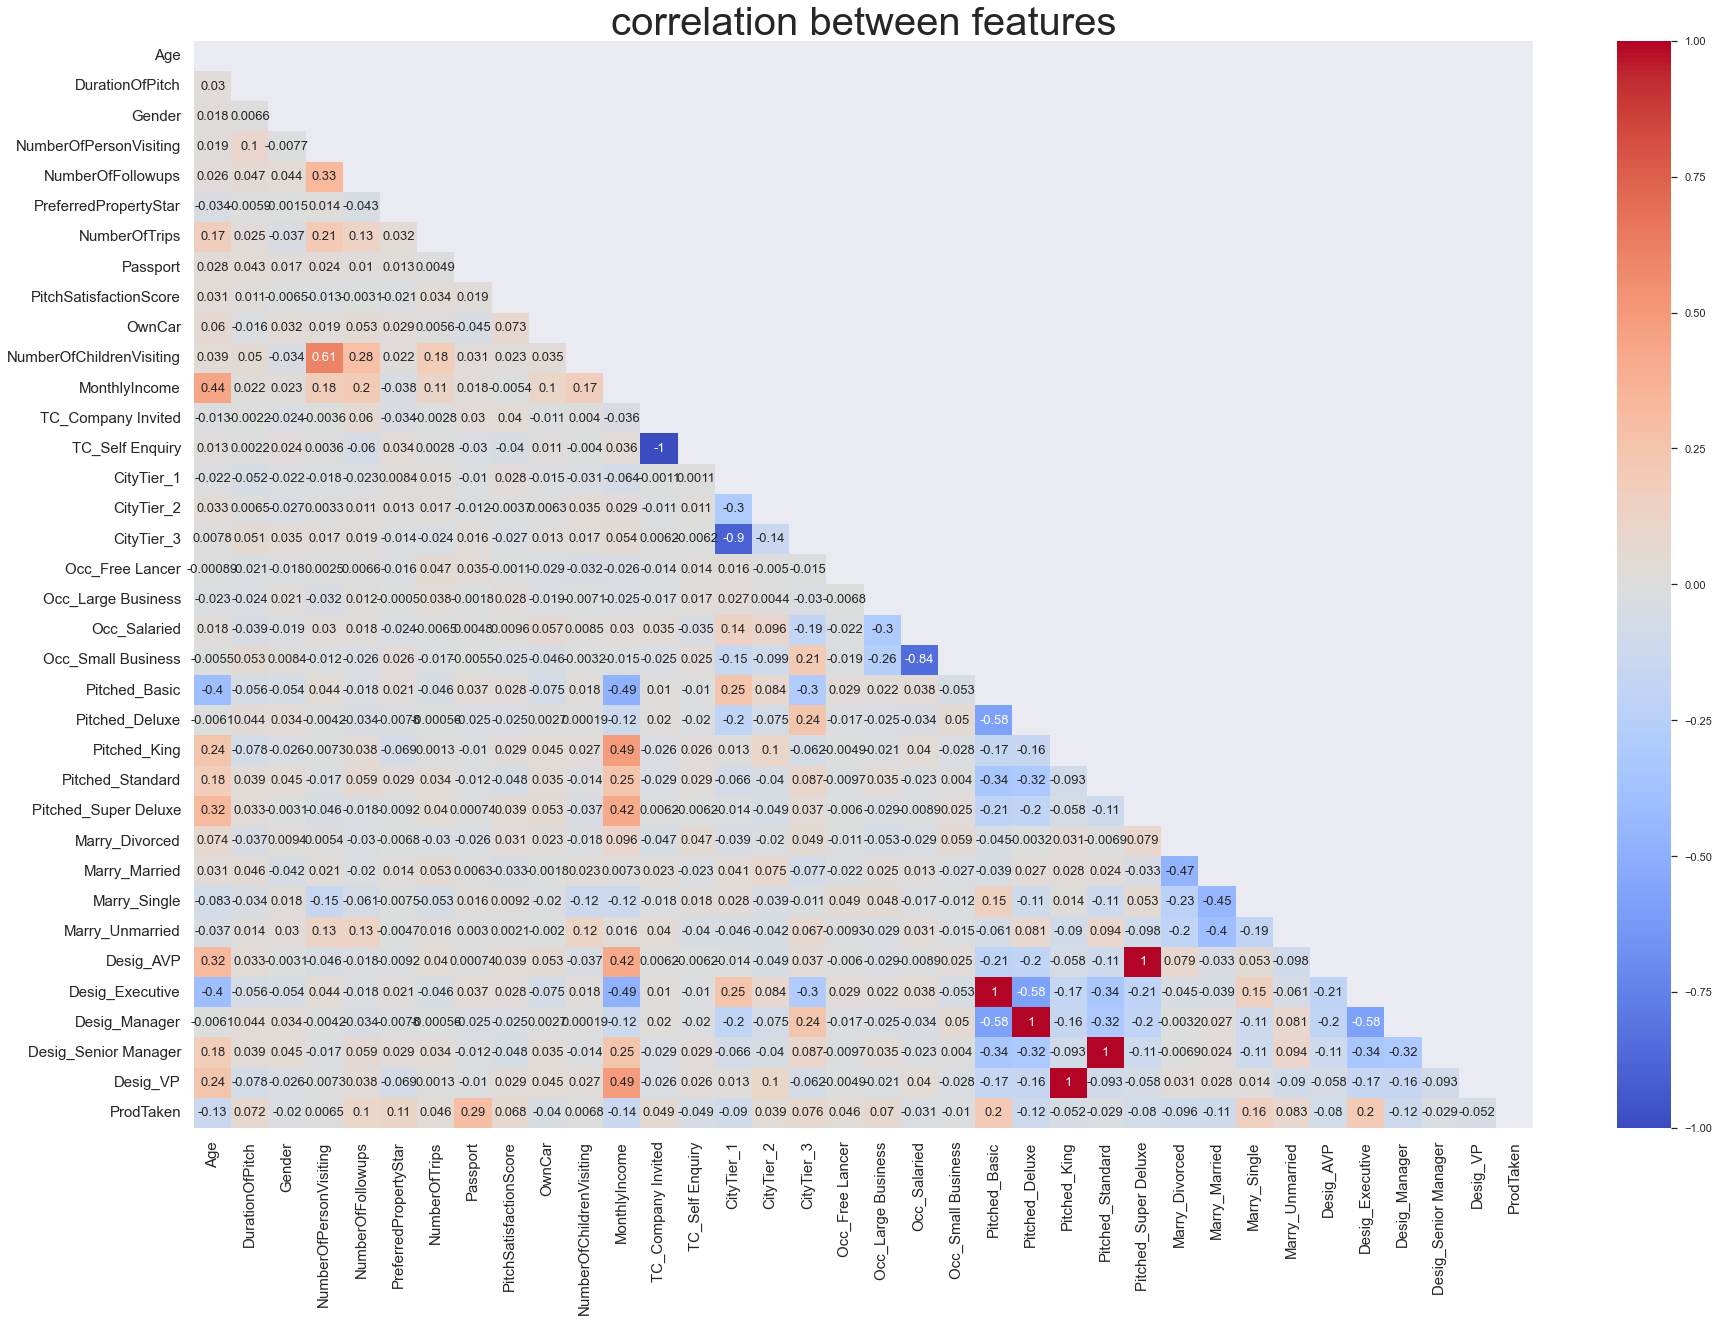

In [173]:
plt.figure(figsize=(30,20))

heat_table = train_corr.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, annot_kws={'size':13}, mask = mask, cmap='coolwarm', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

- 직급(Designation)과 제시상품(ProductPitched)에서 상관계수가 1이 관찰되었다.  
  즉, 직급에 따라 제시하는 상품이 있음을 알 수 있다.


- NumberOfChildrenVisiting과 NumberOfPersonVisiting의 상관계수가 0.61이다.  
  주로 0.7 이상일때 상관관계가 있다고 판단하지만, 추후 NumberOfChildrenVisiting을
  제외하고 모델링을 수행하니 정확도가 더 높게 나와서 NumberOfPersonVisiting만 선택했다.

In [174]:
# id, ProductPitched, NumberOfChildrenVisiting를 제외하고 다시 heatmap 그리기
features = train[['Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager', 'Desig_VP']]

In [175]:
features_corr = train[['Age', 'DurationOfPitch',
       'Gender','NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager',
       'Desig_VP','ProdTaken']]

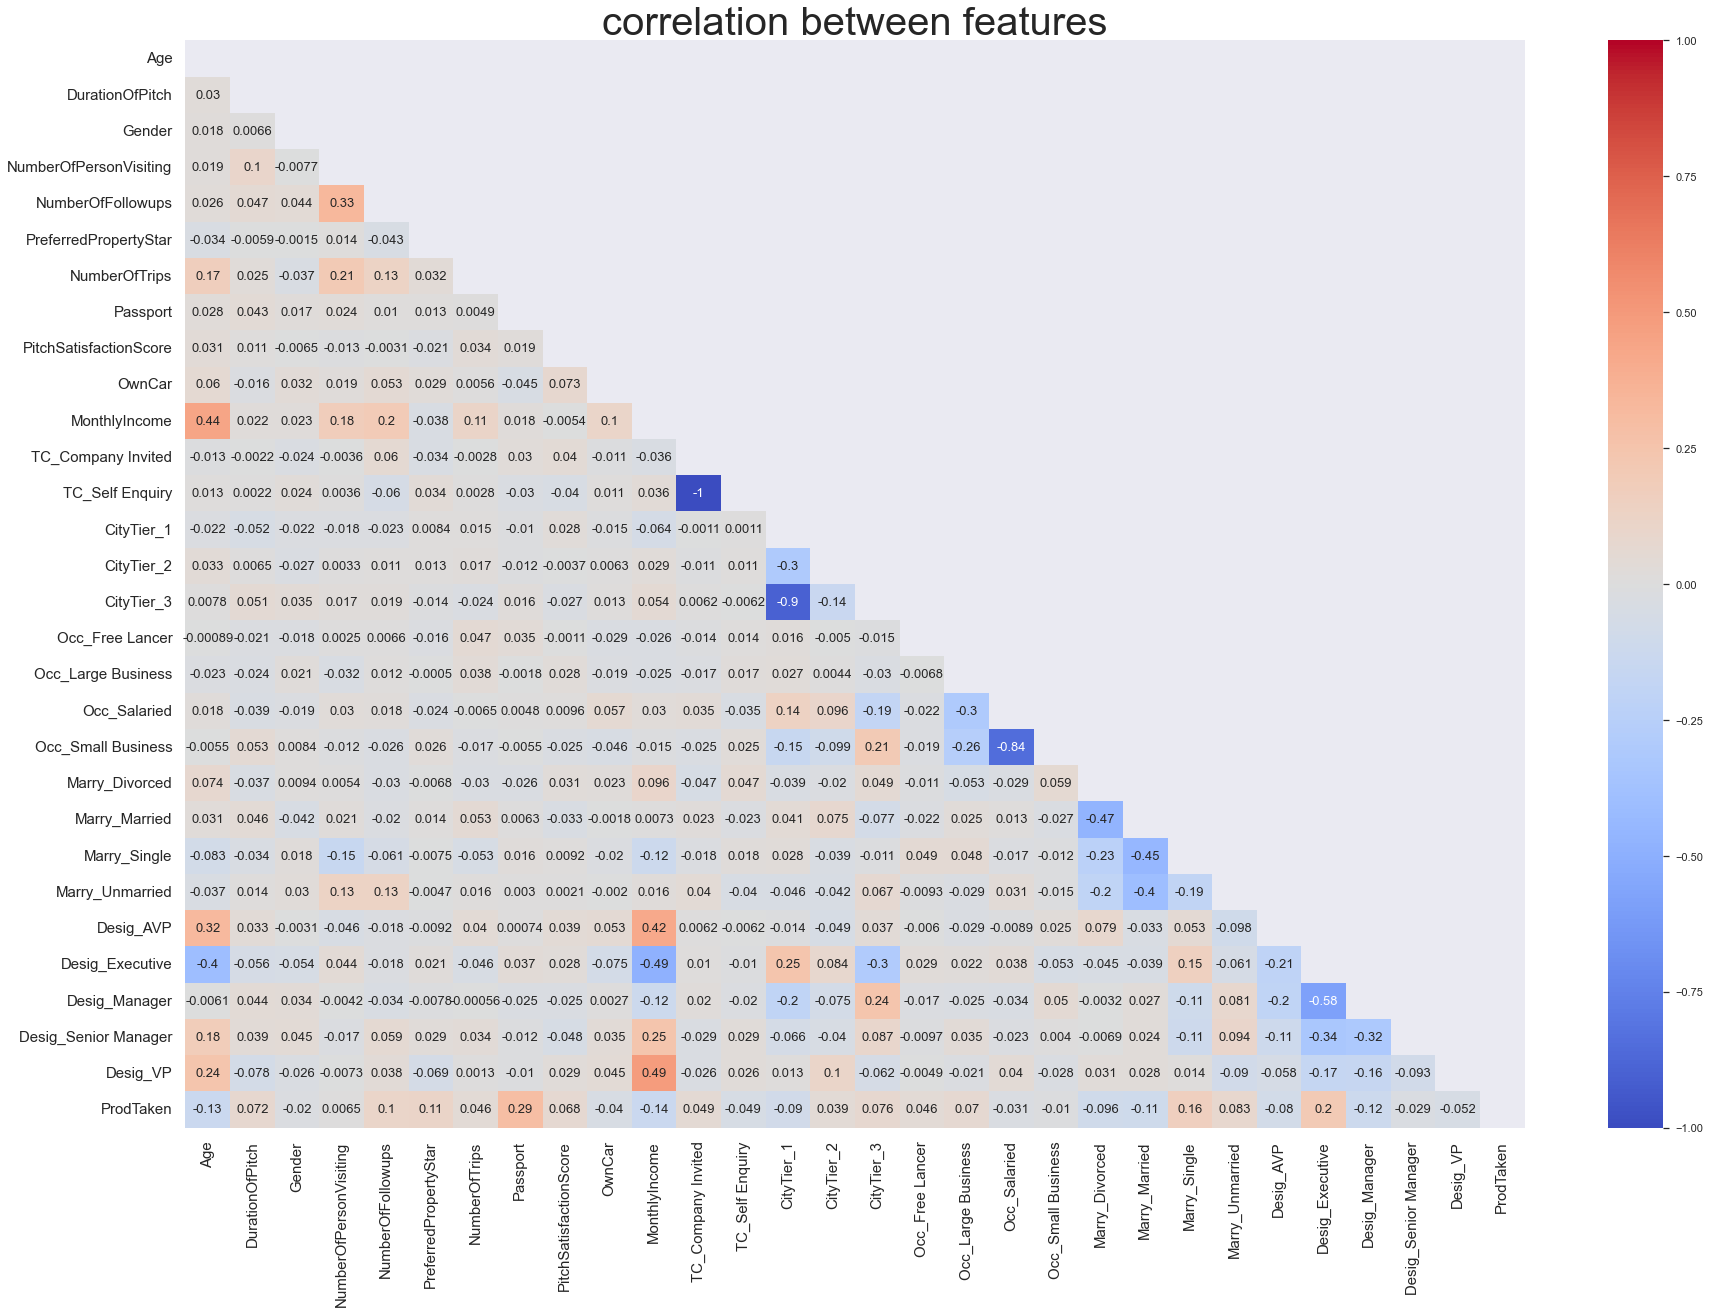

In [176]:
plt.figure(figsize=(30,20))

heat_table = features_corr.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, annot_kws={'size':13}, mask = mask, cmap='coolwarm', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

## 3.2 train(feature, label) 및 test data 설정

In [177]:
features = train[['Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager', 'Desig_VP']]

In [178]:
label = train[['ProdTaken']]

In [179]:
test = test[['Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager', 'Desig_VP']]

train data를 __시험:검증 = 8:2__로 나누어 검증 data를 생성했다.

In [180]:
X_train = features.values
target_label = label.values
X_test = test.values

In [181]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=0)

In [182]:
print(X_tr.shape)
print(X_vld.shape)
print(y_tr.shape)
print(y_vld.shape)

(1564, 29)
(391, 29)
(1564, 1)
(391, 1)


### 3.2.1 검증 modeling (RandomForestClassifier)

In [183]:
model = RandomForestClassifier(random_state=0)
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)
print('The accuracy of the Random Forests is', accuracy_score(prediction,y_vld))

The accuracy of the Random Forests is 0.8670076726342711


- 검증 modeling의 정확도를 기준으로 다양한 방법을 수행했다. (이상치 제거, 다양한 feature 넣고 빼기, 새로운 feature를 만들어(age band 등) 모델링)  
  
(자기 반성) 정확도에 집착하다보니 결국...검증 model에 대해 과적합이 되었다. 처음 참가해보는 대회라 그저 검증 정확도가 오르면 최종 private score도 좋아질 거라 생각한 것이 패착이었다.

<AxesSubplot:>

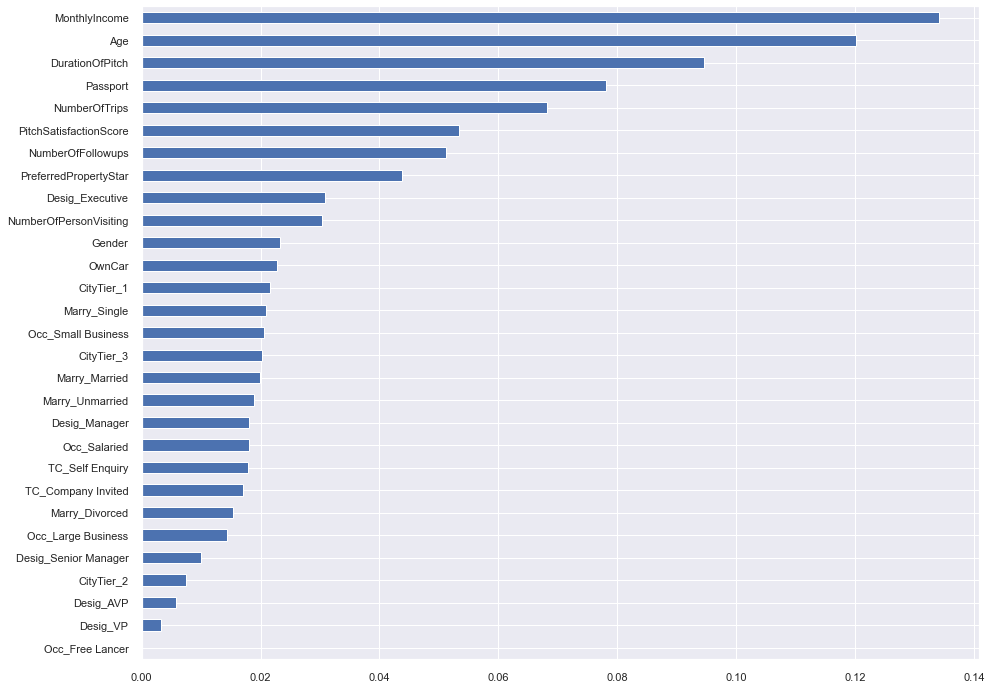

In [184]:
f,ax=plt.subplots(1,1,figsize=(15,12))
pd.Series(model.feature_importances_, features.columns).sort_values(ascending=True).plot.barh()

- 검증 modeling에서 분류에 가장 영향을 많이 주는 feature는 'MonthlyIncome', 'Age', 'DurationOfPitch' 순임을 알 수 있다.  
- 이 feature importance를 통해 다양한 feature를 선택하여 검증을 해 볼 수 있었다.

## 3.3 Simple modeling

In [185]:
label = label.astype(int)

X_train = features
Y_train = label

In [186]:
X_train

,Age,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,MonthlyIncome,TC_Company Invited,TC_Self Enquiry,CityTier_1,CityTier_2,CityTier_3,Occ_Free Lancer,Occ_Large Business,Occ_Salaried,Occ_Small Business,Marry_Divorced,Marry_Married,Marry_Single,Marry_Unmarried,Desig_AVP,Desig_Executive,Desig_Manager,Desig_Senior Manager,Desig_VP
0,0.232558,0.161290,0,3,4.0,3.0,3.0,0,1,0,0.198448,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
1,0.372093,0.290323,1,2,4.0,4.0,1.0,1,5,1,0.190411,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0.627907,0.290323,0,2,3.0,4.0,2.0,0,4,1,0.221288,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,0.255814,0.064516,0,3,5.0,4.0,3.0,0,4,0,0.207560,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
4,0.558140,0.032258,0,2,3.0,3.0,2.0,0,3,1,0.193565,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,0.232558,0.161290,0,3,5.0,3.0,2.0,0,1,1,0.201919,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1951,0.534884,0.096774,1,3,3.0,5.0,1.0,0,5,1,0.313223,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0
1952,0.465116,0.741935,1,3,4.0,3.0,7.0,0,2,1,0.211419,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0
1953,0.232558,0.806452,1,3,5.0,3.0,3.0,0,1,1,0.217224,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0


In [187]:
Y_train

,ProdTaken
0,0
1,1
2,0
3,1
4,0
...,...
1950,0
1951,0
1952,0
1953,0


In [188]:
test

,Age,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,MonthlyIncome,TC_Company Invited,TC_Self Enquiry,CityTier_1,CityTier_2,CityTier_3,Occ_Free Lancer,Occ_Large Business,Occ_Salaried,Occ_Small Business,Marry_Divorced,Marry_Married,Marry_Single,Marry_Unmarried,Desig_AVP,Desig_Executive,Desig_Manager,Desig_Senior Manager,Desig_VP
0,0.325581,0.290323,0,2,5.0,3.0,1.0,0,2,0,0.191118,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
1,0.651163,0.193548,0,3,0.0,4.0,1.0,1,5,0,0.194732,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,0.441860,0.548387,0,3,4.0,3.0,5.0,0,5,1,0.208174,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
3,0.581395,1.000000,0,3,6.0,3.0,6.0,0,3,1,0.224718,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
4,0.162791,0.064516,1,4,4.0,4.0,3.0,1,4,1,0.213764,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,0.837209,0.032258,1,2,3.0,3.0,7.0,0,4,1,0.320727,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
2929,0.348837,0.129032,1,4,2.0,3.0,2.0,0,3,0,0.232734,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2930,0.348837,0.838710,0,4,4.0,3.0,3.0,0,4,1,0.235334,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
2931,0.186047,0.129032,0,4,2.0,5.0,2.0,0,2,1,0.216036,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0


교차 검증을 통해 다양한 모델에 대해서 정확도와 feature importances를 알아보려고 한다. 

In [189]:
kfold = StratifiedKFold(n_splits=10) # kfold 값을 지정

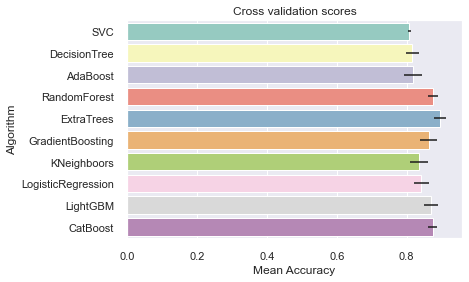

In [190]:
random_state = 2

classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LGBMClassifier())
classifiers.append(CatBoostClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression","LightGBM","CatBoost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [191]:
cv_res.sort_values(by='CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
4,0.895665,0.016923,ExtraTrees
3,0.875207,0.014199,RandomForest
9,0.874184,0.014012,CatBoost
8,0.870081,0.019563,LightGBM
5,0.862923,0.024413,GradientBoosting
7,0.842457,0.020467,LogisticRegression
6,0.836358,0.025916,KNeighboors
2,0.816886,0.025728,AdaBoost
1,0.815863,0.019085,DecisionTree
0,0.807166,0.004349,SVC


In [192]:
cv_res.sort_values(by='CrossValerrors', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
6,0.836358,0.025916,KNeighboors
2,0.816886,0.025728,AdaBoost
5,0.862923,0.024413,GradientBoosting
7,0.842457,0.020467,LogisticRegression
8,0.870081,0.019563,LightGBM
1,0.815863,0.019085,DecisionTree
4,0.895665,0.016923,ExtraTrees
3,0.875207,0.014199,RandomForest
9,0.874184,0.014012,CatBoost
0,0.807166,0.004349,SVC


위의 다양한 모델 중, 

1) Adaboost  
2) ExtraTrees  
3) Random Forest   
4) Gradient boosting  
5) LightGBM  
6) Catboost  
7) SVC

를 결합하여 앙상블 스태킹을 수행하려고 한다. 그 전에 각 모델에 대해 GridSearch CV를 수행하여 가장 정확도가 좋은 parameter를 찾아 best estimator를 앙상블 스태킹에 사용하고자 한다.

### 3.3.1 Adaboost

In [193]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [194]:
gsadaDTC.best_score_

0.8404395604395605

### 3.3.2 ExtraTrees

In [195]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [196]:
gsExtC.best_score_

0.9023207744636317

### 3.3.3 Random Forest

In [197]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [198]:
gsRFC.best_score_

0.894123495552067

### 3.3.4 Gradient boosting

In [199]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [200]:
gsGBC.best_score_

0.8629225536368393

### 3.3.5 LightGBM

In [201]:
LGBM = LGBMClassifier()
lgbm_param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

gsLGBM = GridSearchCV(LGBM,param_grid = lgbm_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLGBM.fit(X_train,Y_train)
 
LGBM_best = gsLGBM.best_estimator_

Fitting 10 folds for each of 63 candidates, totalling 630 fits


In [202]:
gsLGBM.best_score_

0.8700811093668237

### 3.3.6 Catboost

In [203]:
CAT = CatBoostClassifier()
cat_param_grid = {
    'iterations': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7, 9, 11, 13],
}

gsCAT = GridSearchCV(CAT, param_grid = cat_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsCAT.fit(X_train,Y_train)
 
CAT_best = gsCAT.best_estimator_

Fitting 10 folds for each of 126 candidates, totalling 1260 fits
0:	learn: 0.6203644	total: 221ms	remaining: 21.9s
1:	learn: 0.5487376	total: 292ms	remaining: 14.3s
2:	learn: 0.4979015	total: 364ms	remaining: 11.8s
3:	learn: 0.4545224	total: 437ms	remaining: 10.5s
4:	learn: 0.4153463	total: 510ms	remaining: 9.69s
5:	learn: 0.3821885	total: 583ms	remaining: 9.13s
6:	learn: 0.3531778	total: 659ms	remaining: 8.75s
7:	learn: 0.3272324	total: 729ms	remaining: 8.39s
8:	learn: 0.3032495	total: 804ms	remaining: 8.13s
9:	learn: 0.2835407	total: 885ms	remaining: 7.96s
10:	learn: 0.2630342	total: 966ms	remaining: 7.81s
11:	learn: 0.2468760	total: 1.04s	remaining: 7.6s
12:	learn: 0.2332206	total: 1.11s	remaining: 7.44s
13:	learn: 0.2224502	total: 1.18s	remaining: 7.28s
14:	learn: 0.2080859	total: 1.25s	remaining: 7.11s
15:	learn: 0.2036239	total: 1.26s	remaining: 6.61s
16:	learn: 0.1936317	total: 1.33s	remaining: 6.51s
17:	learn: 0.1839645	total: 1.41s	remaining: 6.42s
18:	learn: 0.1746792	total: 

In [204]:
gsCAT.best_score_

0.8941156462585035

### 3.3.7 SVC

In [205]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)
 
SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [206]:
gsSVMC.best_score_

0.8777577184720042

위의 model들의 feature importances를 알아보기 위해 그래프를 그려보았다. (SVC 제외)

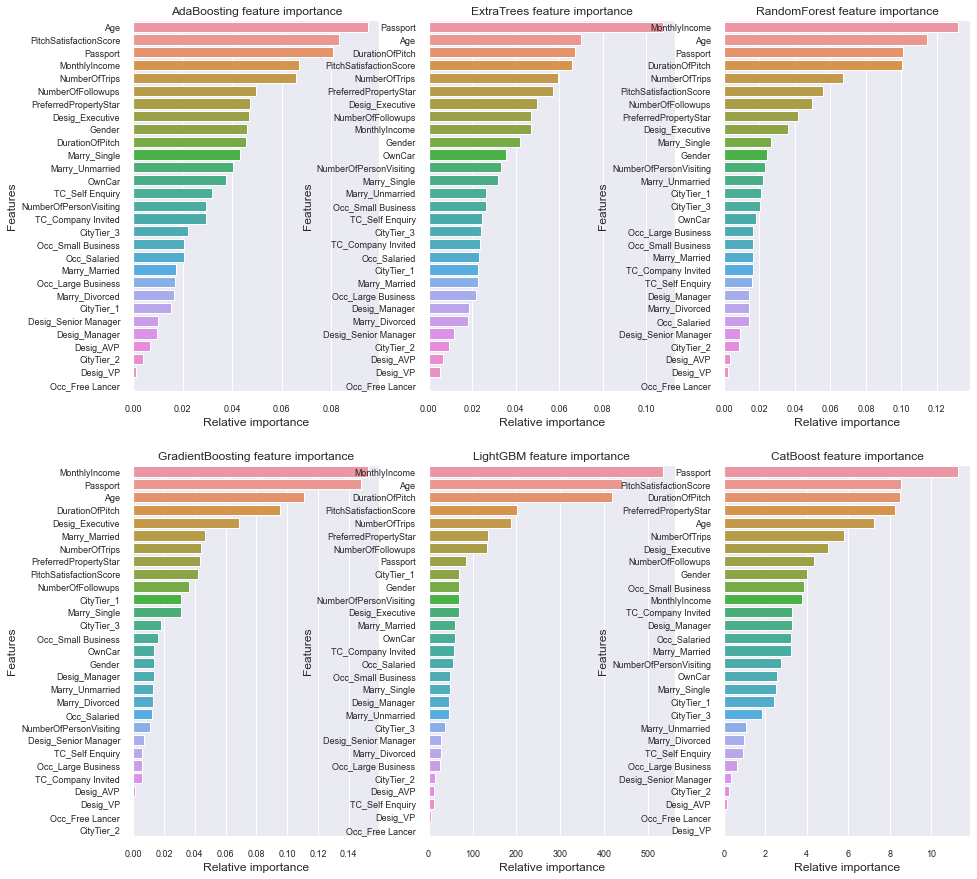

In [207]:
nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best), ("LightGBM", LGBM_best), ("CatBoost", CAT_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

위의 그래프를 보면, 각 model 마다 중요한 feature가 다름을 알 수 있다.  
이러한 model들을 앙상블 하면 조금 더 강력한 modeling이 될 거라 생각했다.

## 3.4 Stacking ensemble

위의 최적화 모델들을 Stacking ensemble 하여 최종 메타 모델이 사용할 학슴 및 테스트 데이터를 생성하기 위한 함수를 만들어주었다.

In [209]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):

    kf = KFold(n_splits=n_folds, shuffle=False)
    
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,'model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index]
        
        model.fit(X_tr, y_tr)
        
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
        
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [210]:
rfc_train, rfc_test = get_stacking_base_datasets(RFC_best, X_train, Y_train, test, 7)
extc_train, extc_test = get_stacking_base_datasets(ExtC_best, X_train, Y_train, test, 7)
svmc_train, svmc_test = get_stacking_base_datasets(SVMC_best, X_train, Y_train, test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_best, X_train, Y_train, test, 7)
gbc_train, gbc_test = get_stacking_base_datasets(GBC_best, X_train, Y_train, test, 7)
lgbm_train, lgbm_test = get_stacking_base_datasets(LGBM_best, X_train, Y_train, test, 7)
cat_train, cat_test = get_stacking_base_datasets(CAT_best, X_train, Y_train, test, 7)

RandomForestClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
ExtraTreesClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
SVC model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
GradientBoostingClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
LGBMClassifier model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
CatBoostClassifier model 시작 
	 폴드 세트:  0  시작 
0:	learn: 0.6508589	total: 789us	remaining: 78.2ms
1:	learn: 0.5832590	

48:	learn: 0.0671789	total: 3s	remaining: 3.13s
49:	learn: 0.0653891	total: 3.07s	remaining: 3.07s
50:	learn: 0.0637101	total: 3.13s	remaining: 3.01s
51:	learn: 0.0620264	total: 3.2s	remaining: 2.95s
52:	learn: 0.0604471	total: 3.26s	remaining: 2.89s
53:	learn: 0.0588509	total: 3.33s	remaining: 2.84s
54:	learn: 0.0585644	total: 3.33s	remaining: 2.73s
55:	learn: 0.0570948	total: 3.4s	remaining: 2.67s
56:	learn: 0.0556949	total: 3.47s	remaining: 2.62s
57:	learn: 0.0545203	total: 3.54s	remaining: 2.56s
58:	learn: 0.0531380	total: 3.6s	remaining: 2.5s
59:	learn: 0.0517634	total: 3.67s	remaining: 2.45s
60:	learn: 0.0505626	total: 3.74s	remaining: 2.39s
61:	learn: 0.0493429	total: 3.8s	remaining: 2.33s
62:	learn: 0.0482380	total: 3.87s	remaining: 2.27s
63:	learn: 0.0472871	total: 3.94s	remaining: 2.21s
64:	learn: 0.0461205	total: 4.01s	remaining: 2.16s
65:	learn: 0.0450399	total: 4.07s	remaining: 2.1s
66:	learn: 0.0440966	total: 4.14s	remaining: 2.04s
67:	learn: 0.0432059	total: 4.2s	remaini

9:	learn: 0.2847158	total: 684ms	remaining: 6.15s
10:	learn: 0.2654981	total: 694ms	remaining: 5.61s
11:	learn: 0.2481866	total: 761ms	remaining: 5.58s
12:	learn: 0.2344114	total: 832ms	remaining: 5.57s
13:	learn: 0.2222251	total: 899ms	remaining: 5.53s
14:	learn: 0.2107345	total: 973ms	remaining: 5.51s
15:	learn: 0.1994882	total: 1.04s	remaining: 5.48s
16:	learn: 0.1898062	total: 1.11s	remaining: 5.42s
17:	learn: 0.1809143	total: 1.18s	remaining: 5.35s
18:	learn: 0.1710711	total: 1.24s	remaining: 5.29s
19:	learn: 0.1631480	total: 1.3s	remaining: 5.22s
20:	learn: 0.1552698	total: 1.37s	remaining: 5.17s
21:	learn: 0.1472500	total: 1.44s	remaining: 5.1s
22:	learn: 0.1410761	total: 1.5s	remaining: 5.04s
23:	learn: 0.1355606	total: 1.57s	remaining: 4.98s
24:	learn: 0.1304951	total: 1.64s	remaining: 4.92s
25:	learn: 0.1245110	total: 1.71s	remaining: 4.85s
26:	learn: 0.1196345	total: 1.77s	remaining: 4.79s
27:	learn: 0.1148822	total: 1.84s	remaining: 4.73s
28:	learn: 0.1105451	total: 1.91s	r

72:	learn: 0.0384446	total: 4.89s	remaining: 1.81s
73:	learn: 0.0377034	total: 4.96s	remaining: 1.74s
74:	learn: 0.0369714	total: 5.04s	remaining: 1.68s
75:	learn: 0.0363170	total: 5.11s	remaining: 1.61s
76:	learn: 0.0355546	total: 5.18s	remaining: 1.55s
77:	learn: 0.0348979	total: 5.25s	remaining: 1.48s
78:	learn: 0.0342657	total: 5.32s	remaining: 1.41s
79:	learn: 0.0336587	total: 5.39s	remaining: 1.35s
80:	learn: 0.0330596	total: 5.47s	remaining: 1.28s
81:	learn: 0.0324624	total: 5.54s	remaining: 1.22s
82:	learn: 0.0319323	total: 5.6s	remaining: 1.15s
83:	learn: 0.0314465	total: 5.68s	remaining: 1.08s
84:	learn: 0.0309568	total: 5.75s	remaining: 1.01s
85:	learn: 0.0304469	total: 5.82s	remaining: 947ms
86:	learn: 0.0299178	total: 5.89s	remaining: 881ms
87:	learn: 0.0294032	total: 5.97s	remaining: 814ms
88:	learn: 0.0289880	total: 6.04s	remaining: 747ms
89:	learn: 0.0285701	total: 6.11s	remaining: 679ms
90:	learn: 0.0281847	total: 6.2s	remaining: 614ms
91:	learn: 0.0277950	total: 6.28s

37:	learn: 0.0946875	total: 2.34s	remaining: 3.82s
38:	learn: 0.0918591	total: 2.41s	remaining: 3.77s
39:	learn: 0.0891877	total: 2.48s	remaining: 3.72s
40:	learn: 0.0864167	total: 2.55s	remaining: 3.67s
41:	learn: 0.0836420	total: 2.62s	remaining: 3.62s
42:	learn: 0.0811161	total: 2.69s	remaining: 3.57s
43:	learn: 0.0784526	total: 2.76s	remaining: 3.51s
44:	learn: 0.0758699	total: 2.82s	remaining: 3.45s
45:	learn: 0.0731489	total: 2.89s	remaining: 3.39s
46:	learn: 0.0711241	total: 2.96s	remaining: 3.33s
47:	learn: 0.0697618	total: 3.02s	remaining: 3.27s
48:	learn: 0.0680004	total: 3.09s	remaining: 3.22s
49:	learn: 0.0664215	total: 3.16s	remaining: 3.16s
50:	learn: 0.0646292	total: 3.23s	remaining: 3.1s
51:	learn: 0.0626735	total: 3.29s	remaining: 3.04s
52:	learn: 0.0613732	total: 3.36s	remaining: 2.98s
53:	learn: 0.0599121	total: 3.43s	remaining: 2.92s
54:	learn: 0.0583280	total: 3.49s	remaining: 2.86s
55:	learn: 0.0569041	total: 3.57s	remaining: 2.8s
56:	learn: 0.0556738	total: 3.64s

In [212]:
Stack_final_X_train = np.concatenate((rfc_train, extc_train, svmc_train, ada_train, gbc_train, lgbm_train, cat_train), axis=1)
Stack_final_X_test = np.concatenate((rfc_test, extc_test, svmc_test, ada_test, gbc_test, lgbm_test,cat_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (1955, 29) 원본 테스트 피처 Shape: (2933, 29)
스태킹 학습 피처 데이터 Shape: (1955, 7) 스태킹 테스트 피처 데이터 Shape: (2933, 7)


stacking train, test data를 최종 예측하기 위해 xgboost 모델을 사용했다.

In [213]:
import xgboost as xgb

gbm = xgb.XGBClassifier(
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    n_jobs= -1,
    scale_pos_weight=1).fit(Stack_final_X_train, Y_train)

prediction = gbm.predict(Stack_final_X_test)

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['ProdTaken'] = prediction

최종 PUBLIC : 0.91133 / PRIVATE : 0.90738로 대회를 마쳤습니다.